In [1]:
import torch

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU")

Using GPU: NVIDIA GeForce RTX 2070 SUPER


In [10]:
# Our proposed model 100 epochs training on MNIST (anomaly detection) V3
# The codes follows our proposed algorithm desgin
# digits 2 and 3 are anomaly numbers
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import CelebA
from torch import optim
from torch.utils import data as dataloader


# Set the random seed and device
SEED = 1
torch.manual_seed(SEED)
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
SAVE_PATH = r"F:\rPPGdata_4\MNIST\best_model_CelebA_parallel_desktop2070.pth"
#best_model_path = r"F:\rPPGdata_4\MNIST\best_model_MNIST_parallel_desktop2070.pth"
BATCH_SIZE = 128
Z_DIM = 300
LOG_INTERVAL = 50

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# # Remove digits 2 and 3 from the test dataset
# test_dataset.data = test_dataset.data[(test_dataset.targets != 2) & (test_dataset.targets != 3)]
# test_dataset.targets = test_dataset.targets[(test_dataset.targets != 2) & (test_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)


def plot_images(original_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy().squeeze()
    reconstructed_images = reconstructed_images.cpu().detach().numpy().squeeze()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


# Define the GumbelSoftmaxVAE model
class GumbelSoftmaxVAE(nn.Module):
    def __init__(self, tau_1=1.0, tau_2=1.0):
        super().__init__()

        self.tau_1 = tau_1
        self.tau_2 = tau_2

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        # Two layers of latent variables
        self.fc_logits_z1 = nn.Linear(256 * 4 * 4, Z_DIM)
        self.fc_logits_z2 = nn.Linear(Z_DIM, Z_DIM)

        # Decoder for each layer
        self.fc_dec1 = nn.Linear(Z_DIM, 256 * 4 * 4)
        self.fc_dec2 = nn.Linear(Z_DIM, 128 * 8 * 8)

        self.conv_trans1_1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv_trans2_1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv_trans3_1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv_trans4_1 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

        self.conv_trans1_2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv_trans2_2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv_trans3_2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)

        logits_z1 = self.fc_logits_z1(x)
        logits_z2 = self.fc_logits_z2(logits_z1)

        return logits_z1, logits_z2

    def reparameterize(self, logits, tau):
        gumbel_noise = torch.rand_like(logits).to(device)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise + 1e-8) + 1e-8)
        z = (logits + gumbel_noise) / tau
        z = F.softmax(z, dim=-1)
        return z


    def decode1(self, z):
        z = self.fc_dec1(z)
        z = z.view(z.size(0), 256, 4, 4)  # reshape
        z = F.relu(self.conv_trans1_1(z))
        z = F.relu(self.conv_trans2_1(z))
        z = F.relu(self.conv_trans3_1(z))
        z = torch.tanh(self.conv_trans4_1(z))
        z = torch.clamp(z, 0, 1)  # Clamp the values between 0 and 1
        return z

    def decode2(self, z):
        z = self.fc_dec2(z)
        z = z.view(z.size(0), 128, 8, 8)  # reshape
        z = F.relu(self.conv_trans1_2(z))
        z = F.relu(self.conv_trans2_2(z))
        z = torch.sigmoid(self.conv_trans3_2(z))
        z = torch.clamp(z, 0, 1)  # Clamp the values between 0 and 1
        return z

    def forward(self, x):
        logits_z1, logits_z2 = self.encode(x)
        z1 = self.reparameterize(logits_z1, self.tau_1)
        z2 = self.reparameterize(logits_z2, self.tau_2)

        x_hat1 = self.decode1(z1)
        x_hat2 = self.decode2(z2)

        # Average the output of the two decoders
        x_hat = (x_hat1 + x_hat2) / 2.0

        return x_hat, logits_z1, logits_z2, z1, z2

    def gumbel_softmax_loss_function(self, recon_x, x, logits_z1, logits_z2, z1, z2):
        # Clamp the values of recon_x between 0 and 1
        recon_x = torch.clamp(recon_x, 0, 1)
        # Binary cross entropy
        xent_loss = F.binary_cross_entropy(recon_x, x, reduction='none')
        xent_loss = torch.sum(xent_loss,dim=[1, 2, 3])

        # KL divergence for each layer
        p_z1 = F.softmax(logits_z1, dim=-1)
        p_z1 = torch.clamp(p_z1, torch.finfo(p_z1.dtype).eps, 1. - torch.finfo(p_z1.dtype).eps)  # to prevent log(0)
        kl_loss_z1 = torch.sum(p_z1 * torch.log(p_z1 * Z_DIM + torch.finfo(p_z1.dtype).eps), dim=-1)

        p_z2 = F.softmax(logits_z2, dim=-1)
        p_z2 = torch.clamp(p_z2, torch.finfo(p_z2.dtype).eps, 1. - torch.finfo(p_z2.dtype).eps)  # to prevent log(0)
        kl_loss_z2 = torch.sum(p_z2 * torch.log(p_z2 * Z_DIM + torch.finfo(p_z2.dtype).eps), dim=-1)

        # Total loss is the sum of the losses for each layer
        vae_loss = torch.mean(xent_loss + kl_loss_z1 + kl_loss_z2)
        return vae_loss

initial_tau_1 = 1.0
initial_tau_2 = 1.0
NUM_EPOCHS = 1000
LOG_INTERVAL = 50
NUM_MODELS = 11
LOSS_THRESHOLD = 0.0001

# Initialize models and optimizers
models = [GumbelSoftmaxVAE().to(device) for _ in range(NUM_MODELS)]
optimizers = [optim.Adam(model.parameters(), lr=1e-3) for model in models]

best_tau_per_epoch_1 = []  # To record the best tau_1 for each epoch
best_tau_per_epoch_2 = []  # To record the best tau_2 for each epoch

# Initialize temperature strategies
initial_taus = [1.0 for _ in range(NUM_MODELS)]
temp_strategies = ['fixed', 'linear_increase', 'linear_decrease', 'exp_increase', 'exp_decrease']
temp_strategies_extended = ['fixed'] + temp_strategies * ((NUM_MODELS - 1) // len(temp_strategies)) + temp_strategies[:((NUM_MODELS - 1) % len(temp_strategies))]
tau_min, tau_max = 0.00001, 10000
lin_increase, lin_decrease = 1.0, 0.005
exp_increase, exp_decrease = 1.05, 0.998
learning_rate = 0.01
patience_threshold = 5
patience_counter = [0 for _ in range(NUM_MODELS)]

# Ensure temp_strategies_extended has correct length
assert len(temp_strategies_extended) == NUM_MODELS, f"Expected {NUM_MODELS} strategies, got {len(temp_strategies_extended)}"

best_global_loss = float('inf')  # Initialize the best global loss with infinity

for epoch in range(NUM_EPOCHS):
    losses = []
    best_reconstruction = None
    original_images = None

    for i in range(NUM_MODELS):
        model = models[i]
        temp_strategy = temp_strategies_extended[i]

        if temp_strategy == 'fixed':
            model.tau_1 = nn.Parameter(torch.tensor(float(initial_taus[i])), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(initial_taus[i])), requires_grad=True)
        elif temp_strategy == 'linear_increase':
            model.tau_1 = nn.Parameter(torch.tensor(float(min(initial_taus[i] + epoch * lin_increase, tau_max))), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(min(initial_taus[i] + epoch * lin_increase, tau_max))), requires_grad=True)
        elif temp_strategy == 'linear_decrease':
            model.tau_1 = nn.Parameter(torch.tensor(float(max(initial_taus[i] - epoch * lin_decrease, tau_min))), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(max(initial_taus[i] - epoch * lin_decrease, tau_min))), requires_grad=True)
        elif temp_strategy == 'exp_increase':
            model.tau_1 = nn.Parameter(torch.tensor(float(min(initial_taus[i] * (exp_increase ** epoch), tau_max))), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(min(initial_taus[i] * (exp_increase ** epoch), tau_max))), requires_grad=True)
        elif temp_strategy == 'exp_decrease':
            model.tau_1 = nn.Parameter(torch.tensor(float(max(initial_taus[i] * (exp_decrease ** epoch), tau_min))), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(max(initial_taus[i] * (exp_decrease ** epoch), tau_min))), requires_grad=True)

        epoch_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizers[i].zero_grad()
            recon_batch, logits_z1, logits_z2, z1, z2 = model(data)
            loss = model.gumbel_softmax_loss_function(recon_batch, data, logits_z1, logits_z2, z1, z2)
            loss.backward()
            optimizers[i].step()
            epoch_loss += loss.item()

            if epoch_loss < LOSS_THRESHOLD and (best_reconstruction is None or loss.item() < min(losses)):
                best_reconstruction = recon_batch
                original_images = data

        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f'Train Epoch: {epoch} \tModel: {i} \tTraining Loss: {epoch_loss} \tTemperature Strategy: {temp_strategy} \ttau_1: {model.tau_1.item()} \ttau_2: {model.tau_2.item()}')

    best_model_idx = np.argmin(losses)
    best_loss = losses[best_model_idx]

    # Check if the current best loss is better than the global best loss
    if best_loss < best_global_loss:
        best_global_loss = best_loss
        best_model_state_dict = copy.deepcopy(models[best_model_idx].state_dict())
        torch.save(models[best_model_idx].state_dict(), SAVE_PATH)  # Save the best model
        print(f'Best model saved with index: {best_model_idx} and loss: {best_loss}')

    for i in range(NUM_MODELS):
        if i != best_model_idx:
            if losses[i] > best_loss:
                patience_counter[i] += 1
                if patience_counter[i] >= patience_threshold:
                    delta_tau = learning_rate * (losses[i] - best_loss) # positive item
                    models[i].tau_1 = nn.Parameter(torch.tensor(float(min(models[i].tau_1.item() + delta_tau, tau_max))), requires_grad=True)
                    models[i].tau_2 = nn.Parameter(torch.tensor(float(min(models[i].tau_2.item() + delta_tau, tau_max))), requires_grad=True)
                    patience_counter[i] = 0

    best_tau_per_epoch_1.append(models[best_model_idx].tau_1.item())
    best_tau_per_epoch_2.append(models[best_model_idx].tau_2.item())

    print(f'Epoch: {epoch} \tBest Model Index: {best_model_idx} \tBest Temperature Strategy: {temp_strategies_extended[best_model_idx]} \tBest tau_1: {models[best_model_idx].tau_1.item()} \tBest tau_2: {models[best_model_idx].tau_2.item()}')

    if best_reconstruction is not None and original_images is not None:
        plot_images(original_images.cpu(), best_reconstruction.cpu())

# Output the best tau for each epoch
for epoch, (tau_1, tau_2) in enumerate(zip(best_tau_per_epoch_1, best_tau_per_epoch_2)):
    print(f"Epoch: {epoch}, Best Tau 1: {tau_1}, Best Tau 2: {tau_2}")

# Plot the best_tau_per_epoch
plt.figure(figsize=(12, 8))
plt.plot(range(NUM_EPOCHS), best_tau_per_epoch_1, label='Best Tau 1 per Epoch')
plt.plot(range(NUM_EPOCHS), best_tau_per_epoch_2, label='Best Tau 2 per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Tau values')
plt.title('Best Tau Values per Epoch')
plt.legend()
plt.show()




Train Epoch: 0 	Model: 0 	Training Loss: 1110.3408072916666 	Temperature Strategy: fixed 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 1 	Training Loss: 923.53473828125 	Temperature Strategy: fixed 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 2 	Training Loss: 861.8771399739584 	Temperature Strategy: linear_increase 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 3 	Training Loss: 889.8464135742188 	Temperature Strategy: linear_decrease 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 4 	Training Loss: 864.8321749674479 	Temperature Strategy: exp_increase 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 5 	Training Loss: 915.3170690104166 	Temperature Strategy: exp_decrease 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 6 	Training Loss: 936.6512241210937 	Temperature Strategy: fixed 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 7 	Training Loss: 863.8594127604167 	Temperature Strategy: linear_increase 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 8 	Training Loss: 907.436509765625 	Te

RuntimeError: Only Tensors of floating point and complex dtype can require gradients

Train Epoch: 0 	Model: 0 	Training Loss: 1111.9426958007812 	Temperature Strategy: fixed 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 1 	Training Loss: 903.0058819986979 	Temperature Strategy: fixed 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 2 	Training Loss: 866.7749803059896 	Temperature Strategy: linear_increase 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 3 	Training Loss: 1008.9857320963541 	Temperature Strategy: linear_decrease 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 4 	Training Loss: 902.2111508789062 	Temperature Strategy: exp_increase 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 5 	Training Loss: 914.7685825195313 	Temperature Strategy: exp_decrease 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 6 	Training Loss: 921.7882316080729 	Temperature Strategy: fixed 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 7 	Training Loss: 959.6561730143229 	Temperature Strategy: linear_increase 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 8 	Training Loss: 910.3179923502604

ValueError: x and y must have same first dimension, but have shapes (1000,) and (185,)

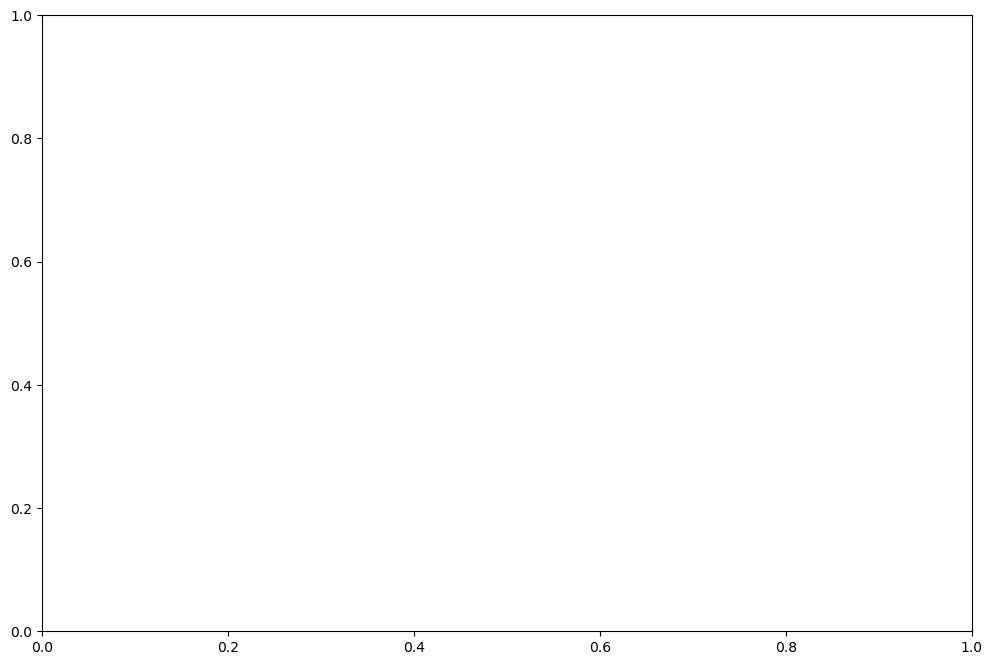

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import CelebA
from torch import optim
from torch.utils import data as dataloader


# Set the random seed and device
SEED = 1
torch.manual_seed(SEED)
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
SAVE_PATH = r"F:\rPPGdata_4\MNIST\best_model_CelebA_parallel_desktop2070.pth"
BATCH_SIZE = 128
Z_DIM = 300
LOG_INTERVAL = 50

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)


def plot_images(original_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy().squeeze()
    reconstructed_images = reconstructed_images.cpu().detach().numpy().squeeze()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


# Define the GumbelSoftmaxVAE model
class GumbelSoftmaxVAE(nn.Module):
    def __init__(self, tau_1=1.0, tau_2=1.0):
        super().__init__()

        self.tau_1 = tau_1
        self.tau_2 = tau_2

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        # Two layers of latent variables
        self.fc_logits_z1 = nn.Linear(256 * 4 * 4, Z_DIM)
        self.fc_logits_z2 = nn.Linear(Z_DIM, Z_DIM)

        # Decoder for each layer
        self.fc_dec1 = nn.Linear(Z_DIM, 256 * 4 * 4)
        self.fc_dec2 = nn.Linear(Z_DIM, 128 * 8 * 8)

        self.conv_trans1_1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv_trans2_1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv_trans3_1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv_trans4_1 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

        self.conv_trans1_2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv_trans2_2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv_trans3_2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)

        logits_z1 = self.fc_logits_z1(x)
        logits_z2 = self.fc_logits_z2(logits_z1)

        return logits_z1, logits_z2

    def reparameterize(self, logits, tau):
        gumbel_noise = torch.rand_like(logits).to(device)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise + 1e-8) + 1e-8)
        z = (logits + gumbel_noise) / tau
        z = F.softmax(z, dim=-1)
        return z


    def decode1(self, z):
        z = self.fc_dec1(z)
        z = z.view(z.size(0), 256, 4, 4)  # reshape
        z = F.relu(self.conv_trans1_1(z))
        z = F.relu(self.conv_trans2_1(z))
        z = F.relu(self.conv_trans3_1(z))
        z = torch.tanh(self.conv_trans4_1(z))
        z = torch.clamp(z, 0, 1)  # Clamp the values between 0 and 1
        return z

    def decode2(self, z):
        z = self.fc_dec2(z)
        z = z.view(z.size(0), 128, 8, 8)  # reshape
        z = F.relu(self.conv_trans1_2(z))
        z = F.relu(self.conv_trans2_2(z))
        z = torch.sigmoid(self.conv_trans3_2(z))
        z = torch.clamp(z, 0, 1)  # Clamp the values between 0 and 1
        return z

    def forward(self, x):
        logits_z1, logits_z2 = self.encode(x)
        z1 = self.reparameterize(logits_z1, self.tau_1)
        z2 = self.reparameterize(logits_z2, self.tau_2)

        x_hat1 = self.decode1(z1)
        x_hat2 = self.decode2(z2)

        # Average the output of the two decoders
        x_hat = (x_hat1 + x_hat2) / 2.0

        return x_hat, logits_z1, logits_z2, z1, z2

    def gumbel_softmax_loss_function(self, recon_x, x, logits_z1, logits_z2, z1, z2):
        # Clamp the values of recon_x between 0 and 1
        recon_x = torch.clamp(recon_x, 0, 1)
        # Binary cross entropy
        xent_loss = F.binary_cross_entropy(recon_x, x, reduction='none')
        xent_loss = torch.sum(xent_loss, dim=[1, 2, 3])

        # KL divergence for each layer
        p_z1 = F.softmax(logits_z1, dim=-1)
        p_z1 = torch.clamp(p_z1, torch.finfo(p_z1.dtype).eps, 1. - torch.finfo(p_z1.dtype).eps)  # to prevent log(0)
        kl_loss_z1 = torch.sum(p_z1 * torch.log(p_z1 * Z_DIM + torch.finfo(p_z1.dtype).eps), dim=-1)

        p_z2 = F.softmax(logits_z2, dim=-1)
        p_z2 = torch.clamp(p_z2, torch.finfo(p_z2.dtype).eps, 1. - torch.finfo(p_z2.dtype).eps)  # to prevent log(0)
        kl_loss_z2 = torch.sum(p_z2 * torch.log(p_z2 * Z_DIM + torch.finfo(p_z2.dtype).eps), dim=-1)

        # Total loss is the sum of the losses for each layer
        vae_loss = torch.mean(xent_loss + kl_loss_z1 + kl_loss_z2)
        return vae_loss

initial_tau_1 = 1.0
initial_tau_2 = 1.0
NUM_EPOCHS = 1000
LOG_INTERVAL = 50
NUM_MODELS = 11
LOSS_THRESHOLD = 0.0001
EARLY_STOP_PATIENCE = 10  # Early stopping patience

# Initialize models and optimizers
models = [GumbelSoftmaxVAE().to(device) for _ in range(NUM_MODELS)]
optimizers = [optim.Adam(model.parameters(), lr=1e-3) for model in models]

best_tau_per_epoch_1 = []  # To record the best tau_1 for each epoch
best_tau_per_epoch_2 = []  # To record the best tau_2 for each epoch

# Initialize temperature strategies
initial_taus = [1.0 for _ in range(NUM_MODELS)]
temp_strategies = ['fixed', 'linear_increase', 'linear_decrease', 'exp_increase', 'exp_decrease']
temp_strategies_extended = ['fixed'] + temp_strategies * ((NUM_MODELS - 1) // len(temp_strategies)) + temp_strategies[:((NUM_MODELS - 1) % len(temp_strategies))]
tau_min, tau_max = 0.00001, 10000
lin_increase, lin_decrease = 0.5, 0.002
exp_increase, exp_decrease = 1.03, 0.999
learning_rate = 0.01
patience_threshold = 5
patience_counter = [0 for _ in range(NUM_MODELS)]

# Ensure temp_strategies_extended has correct length
assert len(temp_strategies_extended) == NUM_MODELS, f"Expected {NUM_MODELS} strategies, got {len(temp_strategies_extended)}"

best_global_loss = float('inf')  # Initialize the best global loss with infinity
early_stop_counter = 0  # Initialize the early stopping counter

for epoch in range(NUM_EPOCHS):
    losses = []
    best_reconstruction = None
    original_images = None

    for i in range(NUM_MODELS):
        model = models[i]
        temp_strategy = temp_strategies_extended[i]

        if temp_strategy == 'fixed':
            model.tau_1 = nn.Parameter(torch.tensor(float(initial_taus[i])), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(initial_taus[i])), requires_grad=True)
        elif temp_strategy == 'linear_increase':
            model.tau_1 = nn.Parameter(torch.tensor(float(min(initial_taus[i] + epoch * lin_increase, tau_max))), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(min(initial_taus[i] + epoch * lin_increase, tau_max))), requires_grad=True)
        elif temp_strategy == 'linear_decrease':
            model.tau_1 = nn.Parameter(torch.tensor(float(max(initial_taus[i] - epoch * lin_decrease, tau_min))), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(max(initial_taus[i] - epoch * lin_decrease, tau_min))), requires_grad=True)
        elif temp_strategy == 'exp_increase':
            model.tau_1 = nn.Parameter(torch.tensor(float(min(initial_taus[i] * (exp_increase ** epoch), tau_max))), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(min(initial_taus[i] * (exp_increase ** epoch), tau_max))), requires_grad=True)
        elif temp_strategy == 'exp_decrease':
            model.tau_1 = nn.Parameter(torch.tensor(float(max(initial_taus[i] * (exp_decrease ** epoch), tau_min))), requires_grad=True)
            model.tau_2 = nn.Parameter(torch.tensor(float(max(initial_taus[i] * (exp_decrease ** epoch), tau_min))), requires_grad=True)

        epoch_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizers[i].zero_grad()
            recon_batch, logits_z1, logits_z2, z1, z2 = model(data)
            loss = model.gumbel_softmax_loss_function(recon_batch, data, logits_z1, logits_z2, z1, z2)
            loss.backward()
            optimizers[i].step()
            epoch_loss += loss.item()

            if epoch_loss < LOSS_THRESHOLD and (best_reconstruction is None or loss.item() < min(losses)):
                best_reconstruction = recon_batch
                original_images = data

        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f'Train Epoch: {epoch} \tModel: {i} \tTraining Loss: {epoch_loss} \tTemperature Strategy: {temp_strategy} \ttau_1: {model.tau_1.item()} \ttau_2: {model.tau_2.item()}')

    best_model_idx = np.argmin(losses)
    best_loss = losses[best_model_idx]

    # Check if the current best loss is better than the global best loss
    if best_loss < best_global_loss:
        best_global_loss = best_loss
        best_model_state_dict = copy.deepcopy(models[best_model_idx].state_dict())
        torch.save(models[best_model_idx].state_dict(), SAVE_PATH)  # Save the best model
        print(f'Best model saved with index: {best_model_idx} and loss: {best_loss}')
        early_stop_counter = 0  # Reset the early stopping counter
    else:
        early_stop_counter += 1  # Increment the early stopping counter

    # Early stopping check
    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break

    for i in range(NUM_MODELS):
        if i != best_model_idx:
            if losses[i] > best_loss:
                patience_counter[i] += 1
                if patience_counter[i] >= patience_threshold:
                    delta_tau = learning_rate * (losses[i] - best_loss)  # positive item
                    models[i].tau_1 = nn.Parameter(torch.tensor(float(min(models[i].tau_1.item() + delta_tau, tau_max))), requires_grad=True)
                    models[i].tau_2 = nn.Parameter(torch.tensor(float(min(models[i].tau_2.item() + delta_tau, tau_max))), requires_grad=True)
                    patience_counter[i] = 0

    best_tau_per_epoch_1.append(models[best_model_idx].tau_1.item())
    best_tau_per_epoch_2.append(models[best_model_idx].tau_2.item())

    print(f'Epoch: {epoch} \tBest Model Index: {best_model_idx} \tBest Temperature Strategy: {temp_strategies_extended[best_model_idx]} \tBest tau_1: {models[best_model_idx].tau_1.item()} \tBest tau_2: {models[best_model_idx].tau_2.item()}')

    if best_reconstruction is not None and original_images is not None:
        plot_images(original_images.cpu(), best_reconstruction.cpu())

# Output the best tau for each epoch
for epoch, (tau_1, tau_2) in enumerate(zip(best_tau_per_epoch_1, best_tau_per_epoch_2)):
    print(f"Epoch: {epoch}, Best Tau 1: {tau_1}, Best Tau 2: {tau_2}")

# Plot the best_tau_per_epoch
plt.figure(figsize=(12, 8))
plt.plot(range(NUM_EPOCHS), best_tau_per_epoch_1, label='Best Tau 1 per Epoch')
plt.plot(range(NUM_EPOCHS), best_tau_per_epoch_2, label='Best Tau 2 per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Tau values')
plt.title('Best Tau Values per Epoch')
plt.legend()
plt.show()


Epoch: 0, Best Tau 1: 1.0, Best Tau 2: 1.0
Epoch: 1, Best Tau 1: 2.0, Best Tau 2: 2.0
Epoch: 2, Best Tau 1: 3.0, Best Tau 2: 3.0
Epoch: 3, Best Tau 1: 4.0, Best Tau 2: 4.0
Epoch: 4, Best Tau 1: 5.0, Best Tau 2: 5.0
Epoch: 5, Best Tau 1: 6.0, Best Tau 2: 6.0
Epoch: 6, Best Tau 1: 7.0, Best Tau 2: 7.0
Epoch: 7, Best Tau 1: 8.0, Best Tau 2: 8.0
Epoch: 8, Best Tau 1: 9.0, Best Tau 2: 9.0
Epoch: 9, Best Tau 1: 10.0, Best Tau 2: 10.0
Epoch: 10, Best Tau 1: 11.0, Best Tau 2: 11.0
Epoch: 11, Best Tau 1: 12.0, Best Tau 2: 12.0
Epoch: 12, Best Tau 1: 13.0, Best Tau 2: 13.0
Epoch: 13, Best Tau 1: 14.0, Best Tau 2: 14.0
Epoch: 14, Best Tau 1: 15.0, Best Tau 2: 15.0
Epoch: 15, Best Tau 1: 16.0, Best Tau 2: 16.0
Epoch: 16, Best Tau 1: 17.0, Best Tau 2: 17.0
Epoch: 17, Best Tau 1: 18.0, Best Tau 2: 18.0
Epoch: 18, Best Tau 1: 19.0, Best Tau 2: 19.0
Epoch: 19, Best Tau 1: 20.0, Best Tau 2: 20.0
Epoch: 20, Best Tau 1: 21.0, Best Tau 2: 21.0
Epoch: 21, Best Tau 1: 22.0, Best Tau 2: 22.0
Epoch: 22, Best 

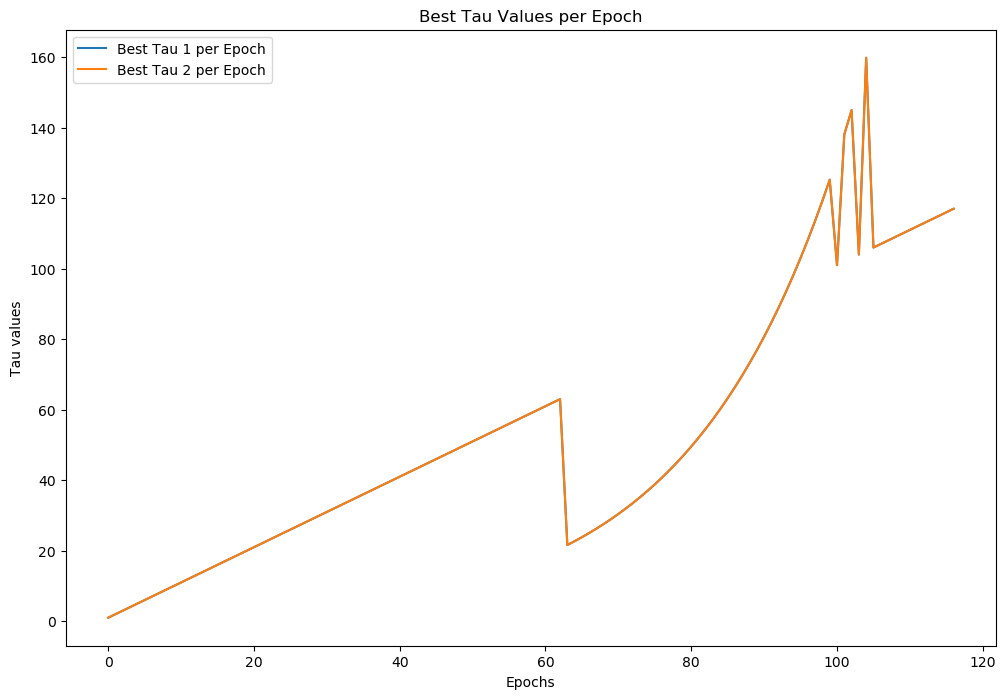

In [69]:
# Output the best tau for each epoch
for epoch, (tau_1, tau_2) in enumerate(zip(best_tau_per_epoch_1, best_tau_per_epoch_2)):
    print(f"Epoch: {epoch}, Best Tau 1: {tau_1}, Best Tau 2: {tau_2}")

# Plot the best_tau_per_epoch
plt.figure(figsize=(12, 8))
plt.plot(range(117), best_tau_per_epoch_1, label='Best Tau 1 per Epoch')
plt.plot(range(117), best_tau_per_epoch_2, label='Best Tau 2 per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Tau values')
plt.title('Best Tau Values per Epoch')
plt.legend()
plt.show()


In [83]:
# index 2 means the model 2 by using exponential increasing temperature strategy
best_model_path = r"F:\rPPGdata_4\MNIST\best_model_MNIST_parallel_desktop2070.pth"

torch.save(models[best_model_idx].state_dict(), best_model_path)
print(f'Best model saved with index: {best_model_idx}')

Best model saved with index: 2


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torch import optim

# Set the random seed and device
SEED = 1
torch.manual_seed(SEED)
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
SAVE_PATH = r"F:\rPPGdata_4\MNIST\best_model_mnist_parallel_desktop2070_v1.pth"
BATCH_SIZE = 128
Z_DIM = 300

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Define the GumbelSoftmaxVAE model
class GumbelSoftmaxVAE(nn.Module):
    def __init__(self, tau_1=1.0, tau_2=1.0):
        super().__init__()

        self.tau_1 = tau_1
        self.tau_2 = tau_2

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        # Two layers of latent variables
        self.fc_logits_z1 = nn.Linear(256 * 4 * 4, Z_DIM)
        self.fc_logits_z2 = nn.Linear(Z_DIM, Z_DIM)

        # Decoder for each layer
        self.fc_dec1 = nn.Linear(Z_DIM, 256 * 4 * 4)
        self.fc_dec2 = nn.Linear(Z_DIM, 128 * 8 * 8)

        self.conv_trans1_1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv_trans2_1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv_trans3_1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv_trans4_1 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

        self.conv_trans1_2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv_trans2_2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv_trans3_2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)

        logits_z1 = self.fc_logits_z1(x)
        logits_z2 = self.fc_logits_z2(logits_z1)

        return logits_z1, logits_z2

    def reparameterize(self, logits, tau):
        gumbel_noise = torch.rand_like(logits).to(device)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise + 1e-8) + 1e-8)
        z = (logits + gumbel_noise) / tau
        z = F.softmax(z, dim=-1)
        return z

    def decode1(self, z):
        z = self.fc_dec1(z)
        z = z.view(z.size(0), 256, 4, 4)  # reshape
        z = F.relu(self.conv_trans1_1(z))
        z = F.relu(self.conv_trans2_1(z))
        z = F.relu(self.conv_trans3_1(z))
        z = torch.tanh(self.conv_trans4_1(z))
        z = torch.clamp(z, 0, 1)  # Clamp the values between 0 and 1
        return z

    def decode2(self, z):
        z = self.fc_dec2(z)
        z = z.view(z.size(0), 128, 8, 8)  # reshape
        z = F.relu(self.conv_trans1_2(z))
        z = F.relu(self.conv_trans2_2(z))
        z = torch.sigmoid(self.conv_trans3_2(z))
        z = torch.clamp(z, 0, 1)  # Clamp the values between 0 and 1
        return z

    def forward(self, x):
        logits_z1, logits_z2 = self.encode(x)
        z1 = self.reparameterize(logits_z1, self.tau_1)
        z2 = self.reparameterize(logits_z2, self.tau_2)

        x_hat1 = self.decode1(z1)
        x_hat2 = self.decode2(z2)

        # Average the output of the two decoders
        x_hat = (x_hat1 + x_hat2) / 2.0

        return x_hat, logits_z1, logits_z2, z1, z2

    def gumbel_softmax_loss_function(self, recon_x, x, logits_z1, logits_z2, z1, z2):
        # Clamp the values of recon_x between 0 and 1
        recon_x = torch.clamp(recon_x, 0, 1)
        # Binary cross entropy
        xent_loss = F.binary_cross_entropy(recon_x, x, reduction='none')
        xent_loss = torch.sum(xent_loss, dim=[1, 2, 3])

        # KL divergence for each layer
        p_z1 = F.softmax(logits_z1, dim=-1)
        p_z1 = torch.clamp(p_z1, torch.finfo(p_z1.dtype).eps, 1. - torch.finfo(p_z1.dtype).eps)  # to prevent log(0)
        kl_loss_z1 = torch.sum(p_z1 * torch.log(p_z1 * Z_DIM + torch.finfo(p_z1.dtype).eps), dim=-1)

        p_z2 = F.softmax(logits_z2, dim=-1)
        p_z2 = torch.clamp(p_z2, torch.finfo(p_z2.dtype).eps, 1. - torch.finfo(p_z2.dtype).eps)  # to prevent log(0)
        kl_loss_z2 = torch.sum(p_z2 * torch.log(p_z2 * Z_DIM + torch.finfo(p_z2.dtype).eps), dim=-1)

        # Total loss is the sum of the losses for each layer
        vae_loss = torch.mean(xent_loss + kl_loss_z1 + kl_loss_z2)
        return vae_loss

# Load the saved model
best_model = GumbelSoftmaxVAE().to(device)
state_dict = torch.load(SAVE_PATH)
# Remove the 'tau_1' and 'tau_2' keys
state_dict.pop('tau_1', None)
state_dict.pop('tau_2', None)
best_model.load_state_dict(state_dict)
best_model.tau_1 = 93.0
best_model.tau_2 = 93.0
best_model.eval()



GumbelSoftmaxVAE(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_logits_z1): Linear(in_features=4096, out_features=300, bias=True)
  (fc_logits_z2): Linear(in_features=300, out_features=300, bias=True)
  (fc_dec1): Linear(in_features=300, out_features=4096, bias=True)
  (fc_dec2): Linear(in_features=300, out_features=8192, bias=True)
  (conv_trans1_1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_trans2_1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_trans3_1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_trans4_1): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_trans1_2)

Average MSE: 0.0005236932108196418
Average SSIM: 0.990544261841153


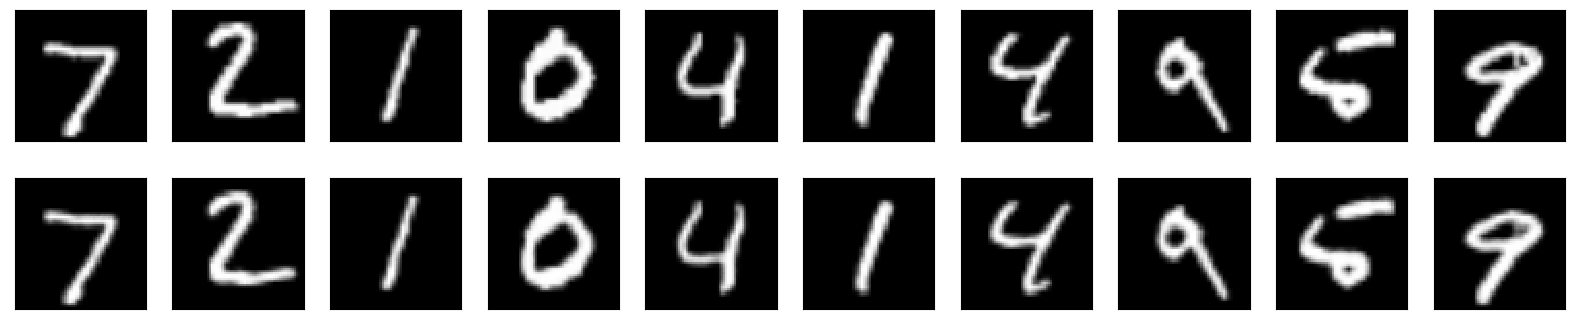

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Function to plot images
def plot_images(original_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Calculate MSE and SSIM for the entire test dataset
mse_losses = []
ssim_values = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)

        # Reconstruct the images
        recon_batch, _, _, _, _ = best_model(data)

        # Calculate MSE loss
        mse_loss = F.mse_loss(recon_batch, data)
        mse_losses.append(mse_loss.item())

        # Calculate SSIM
        for i in range(data.size(0)):
            original = data[i].cpu().numpy().transpose(1, 2, 0).squeeze()
            reconstruction = recon_batch[i].cpu().numpy().transpose(1, 2, 0).squeeze()
            ssim_value = ssim(original, reconstruction, data_range=reconstruction.max() - reconstruction.min())
            ssim_values.append(ssim_value)

# Calculate average MSE and SSIM
avg_mse = np.mean(mse_losses)
avg_ssim = np.mean(ssim_values)

print(f'Average MSE: {avg_mse}')
print(f'Average SSIM: {avg_ssim}')

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Pass the images through the best model
recon_batch, _, _, _, _ = best_model(data)

# Plot the original and reconstructed images
plot_images(data.cpu(), recon_batch.cpu())


C:\Users\zhouf\.conda\envs\old13\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\zhouf\.conda\envs\old13\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


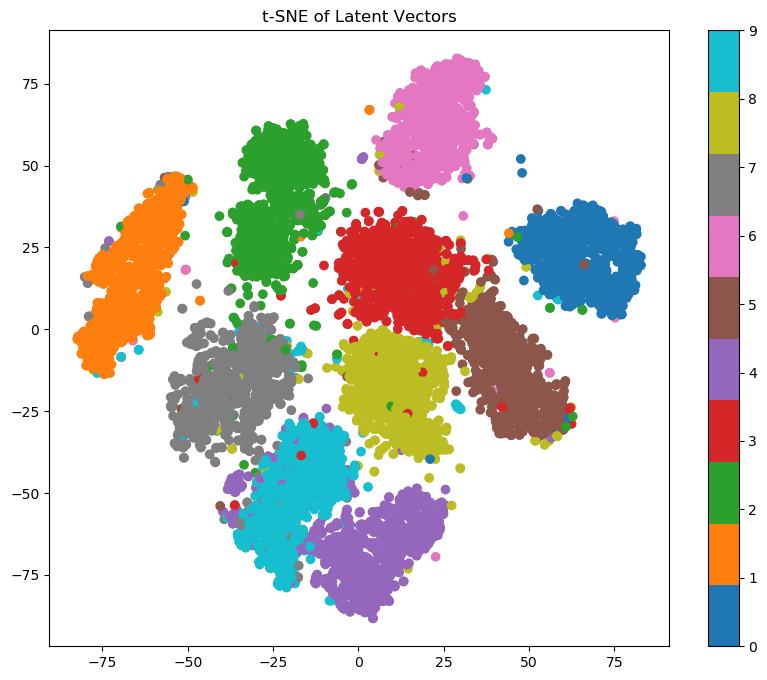

In [7]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
batch_size = 128

def get_latent_vectors(model, data):
    with torch.no_grad():
        _, _, _, _, z = model(data)
        return z


all_latent_vectors = []
all_labels = []


for data, labels in test_loader:
    data = data.to(device)
    latent_vectors = get_latent_vectors(best_model, data).cpu().detach().numpy()
    all_latent_vectors.append(latent_vectors)
    all_labels.append(labels.numpy())

    if len(all_latent_vectors) * batch_size > 10000:
        break


all_latent_vectors = np.concatenate(all_latent_vectors, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


tsne = TSNE(n_components=2, random_state=0)
all_latent_tsne = tsne.fit_transform(all_latent_vectors)


plt.figure(figsize=(10, 8))
plt.scatter(all_latent_tsne[:, 0], all_latent_tsne[:, 1], c=all_labels, cmap='tab10')
plt.colorbar()
plt.title('t-SNE of Latent Vectors')
plt.show()


C:\Users\zhouf\.conda\envs\old13\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


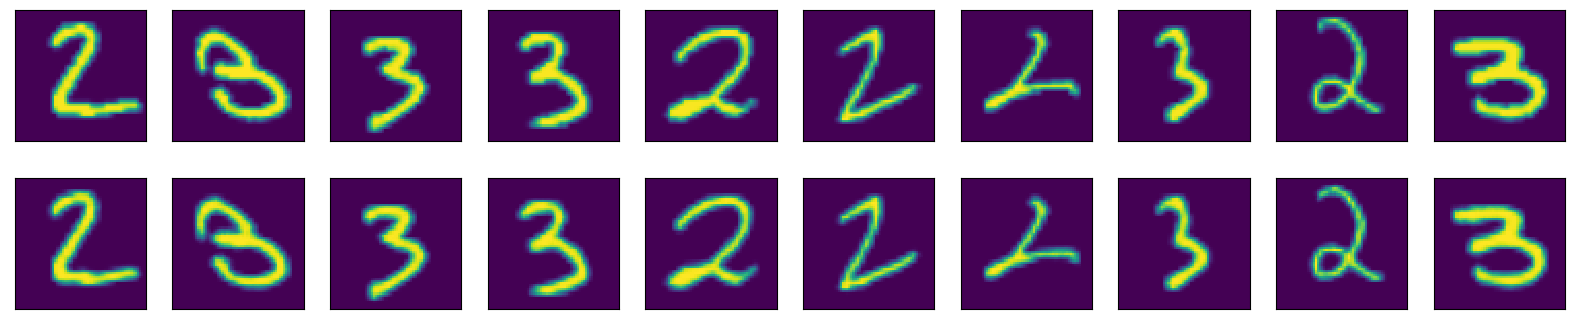

In [8]:
# Results of my parallel GS-VAEs on MNIST reconstruction of unseen digits (2s and 3s)
def plot_images(original_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Pass the images through the best model
recon_batch, _, _, _, _ = best_model(data)

# Plot the original and reconstructed images
plot_images(data.cpu(), recon_batch.cpu())


C:\Users\zhouf\.conda\envs\old13\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


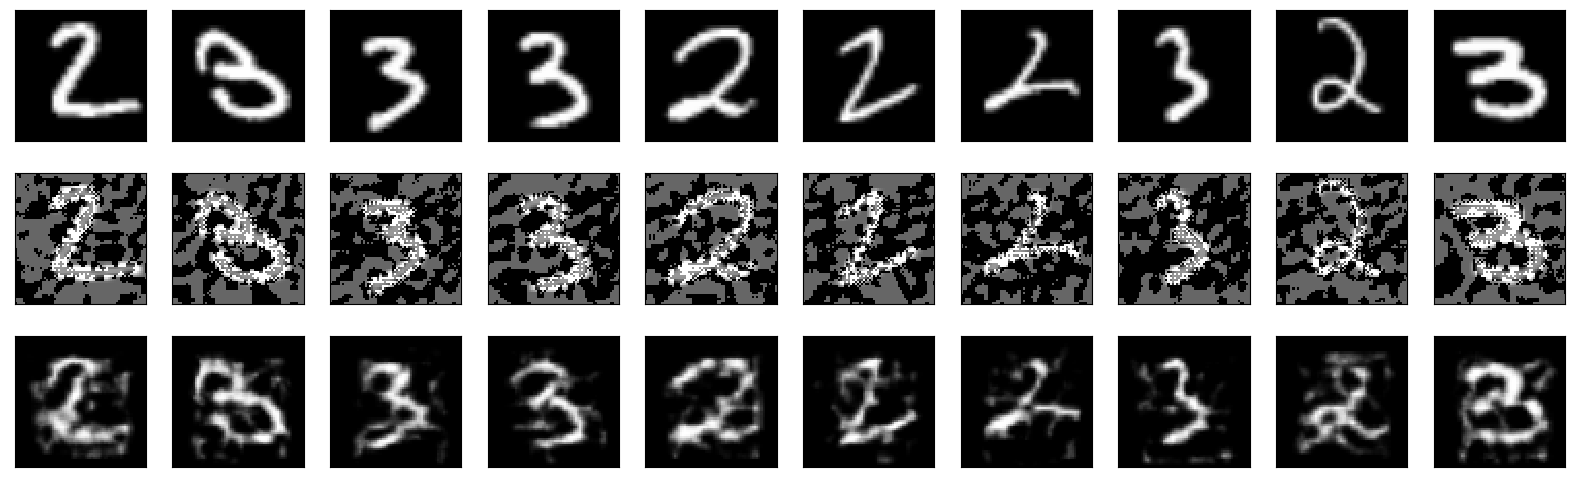

In [11]:
# Test the models performance for reconstruction under high-intensity FGSM adversarial attacks
# The models were trained by the dataset without 2s and 3s
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust input image size to match the model's expected input size
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set FGSM attack parameters
epsilon = 0.4  # Attack strength

# Need to calculate the gradient of the data
data.requires_grad = True

# Get model predictions on the original data
output, _, _, _, _ = best_model(data)
loss = F.mse_loss(output, data)
best_model.zero_grad()
loss.backward()

# Generate adversarial samples
data_grad = data.grad.data
perturbed_data = fgsm_attack(data, epsilon, data_grad)

# Reconstruct adversarial samples
recon_batch = best_model(perturbed_data)[0]

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
plot_images(data, perturbed_data, recon_batch)


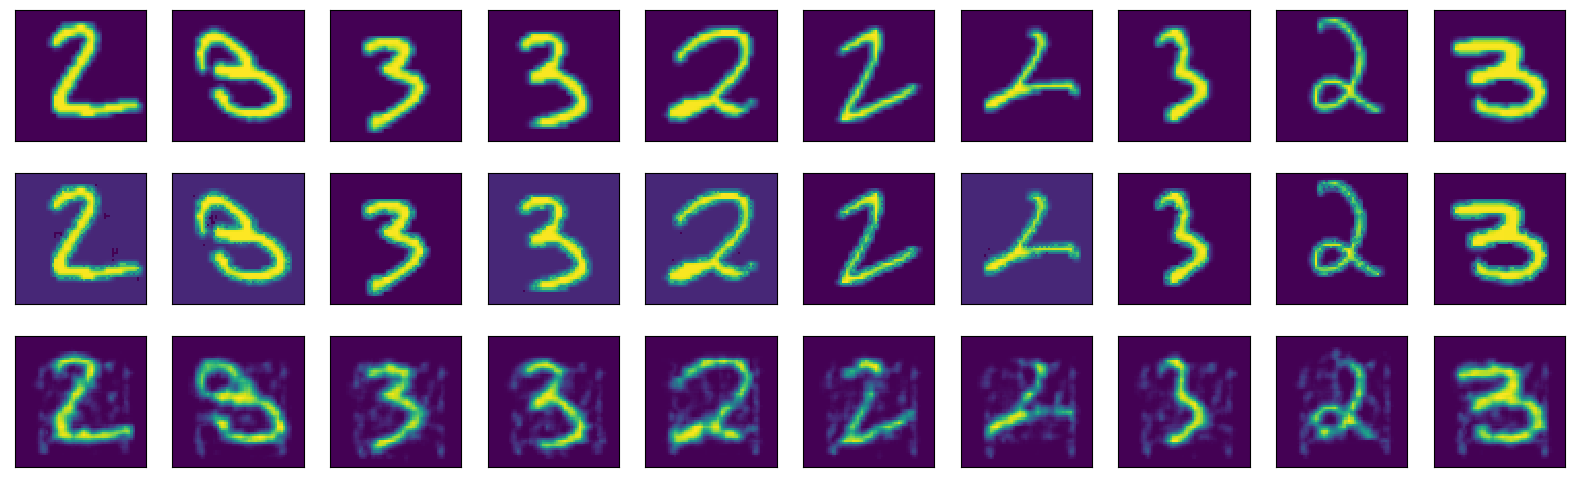

In [12]:
# Test performance of reconstruction under FGSM attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# FGSM attack function
def fgsm_attack(data, epsilon, gradient):
    sign_data_grad = gradient.sign()
    perturbed_data = data + epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set FGSM attack parameters
epsilon = 0.1  # Attack strength

# Need to calculate the gradient of the data
data.requires_grad = True

# Get model predictions on the original data
output, _, _, _, _ = best_model(data)
loss = F.binary_cross_entropy(output, data)
best_model.zero_grad()
loss.backward()

# Generate adversarial samples
data_grad = data.grad.data
perturbed_data = fgsm_attack(data, epsilon, data_grad)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = best_model(perturbed_data)

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
plot_images(data.cpu().detach(), perturbed_data.cpu().detach(), recon_batch.cpu().detach())


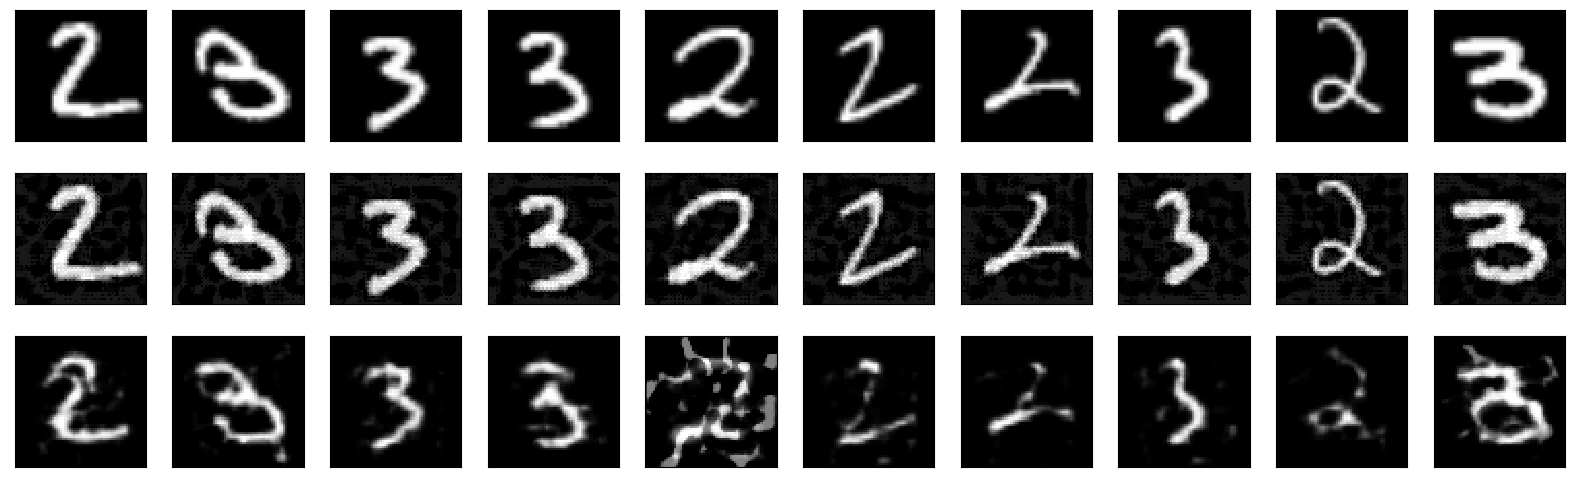

In [16]:
# Test the models performance for reconstruction under high-intensity PGD adversarial attacks
# The models were trained by the dataset without 2s and 3s
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust input image size to match the model's expected input size
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# PGD attack function
def pgd_attack(model, images, epsilon, alpha, num_iter):
    images = images.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(images)
        loss = F.mse_loss(output, images)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_images = images + alpha * images.grad.sign()
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
            perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
            images = perturbed_images.detach().requires_grad_(True)
    return images

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.5  # Maximum perturbation
alpha = 0.01   # Step size, increased to make attack stronger
num_iter = 10  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(best_model, data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch = best_model(perturbed_data)[0]

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data, perturbed_data, recon_batch)


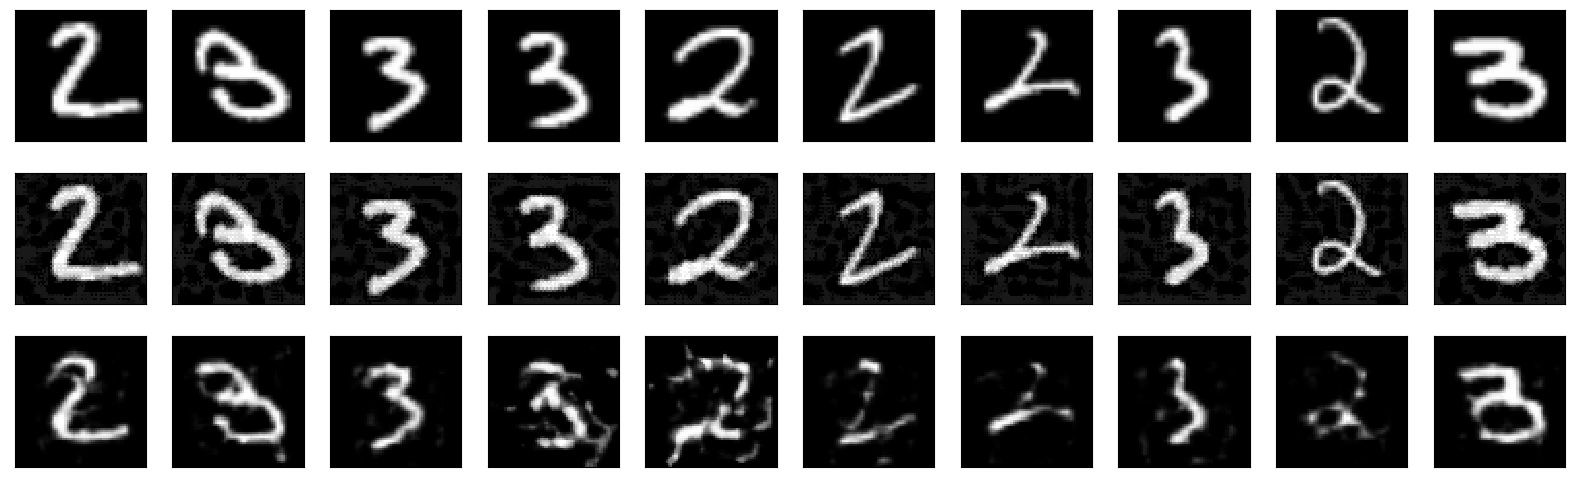

In [21]:
# Test the models performance for reconstruction under high-intensity PGD adversarial attacks
# The models were trained by the dataset without 2s and 3s
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust input image size to match the model's expected input size
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# PGD attack function
def pgd_attack(model, images, epsilon, alpha, num_iter):
    images = images.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(images)
        loss = F.mse_loss(output, images)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_images = images + alpha * images.grad.sign()
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
            perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
            images = perturbed_images.detach().requires_grad_(True)
    return images

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.1  # Maximum perturbation
alpha = 0.01   # Step size, increased to make attack stronger
num_iter = 10  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(best_model, data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch = best_model(perturbed_data)[0]

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data, perturbed_data, recon_batch)


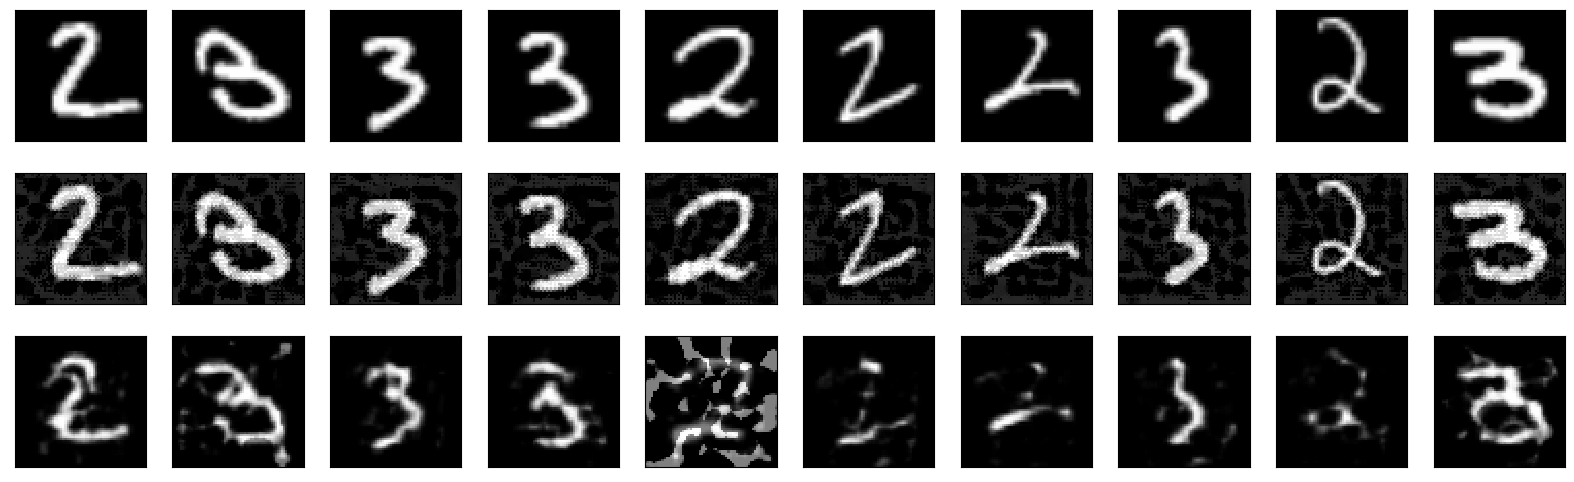

In [24]:
# Test the models performance for reconstruction under high-intensity PGD adversarial attacks
# The models were trained by the dataset without 2s and 3s
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust input image size to match the model's expected input size
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# PGD attack function
def pgd_attack(model, images, epsilon, alpha, num_iter):
    images = images.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(images)
        loss = F.mse_loss(output, images)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_images = images + alpha * images.grad.sign()
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
            perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
            images = perturbed_images.detach().requires_grad_(True)
    return images

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.1  # Maximum perturbation
alpha = 0.01   # Step size, increased to make attack stronger
num_iter = 15  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(best_model, data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch = best_model(perturbed_data)[0]

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data, perturbed_data, recon_batch)


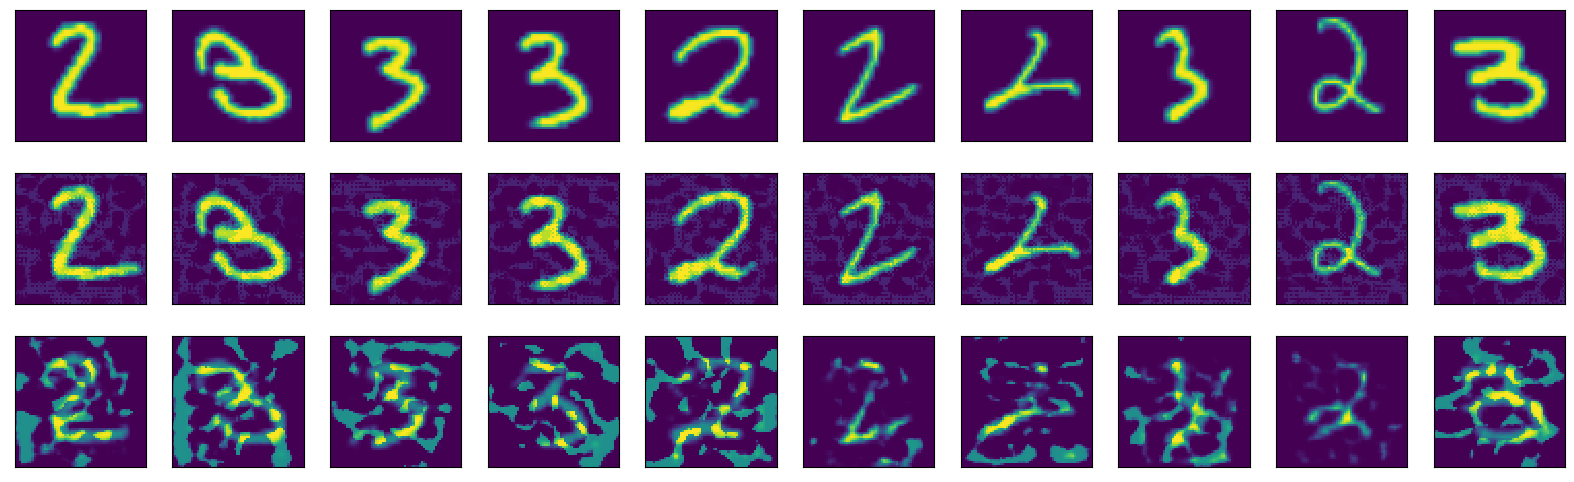

In [25]:
# Test performance of reconstruction under PGD attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# PGD attack function
def pgd_attack(model, data, epsilon, alpha, num_iter):
    perturbed_data = data.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(perturbed_data)
        loss = F.binary_cross_entropy(output, data)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_data += alpha * perturbed_data.grad.sign()
            perturbed_data = torch.clamp(perturbed_data, 0, 1)
            perturbed_data = torch.max(torch.min(perturbed_data, data + epsilon), data - epsilon)
            perturbed_data = perturbed_data.detach().requires_grad_(True)
    return perturbed_data

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.1  # Maximum perturbation
alpha = 0.01   # Step size
num_iter = 20  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(best_model, data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = best_model(perturbed_data)

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data.cpu(), perturbed_data.cpu(), recon_batch.cpu())


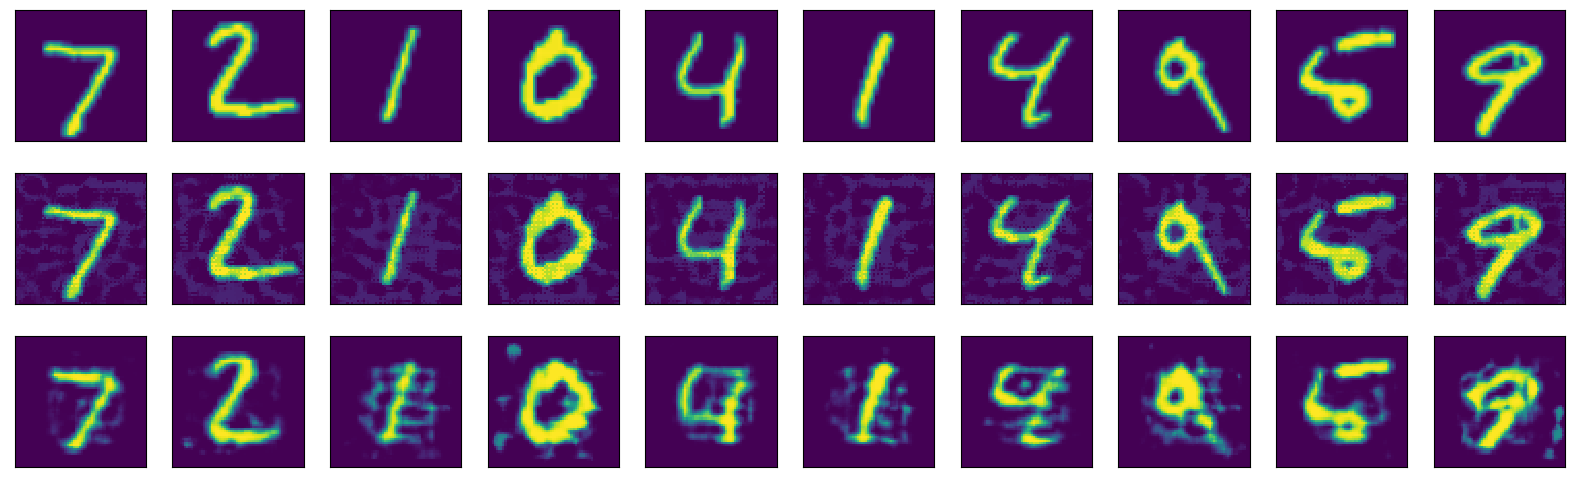

In [91]:
# Test performance of reconstruction under PGD attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# PGD attack function
def pgd_attack(model, data, epsilon, alpha, num_iter):
    perturbed_data = data.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(perturbed_data)
        loss = F.binary_cross_entropy(output, data)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_data += alpha * perturbed_data.grad.sign()
            perturbed_data = torch.clamp(perturbed_data, 0, 1)
            perturbed_data = torch.max(torch.min(perturbed_data, data + epsilon), data - epsilon)
            perturbed_data = perturbed_data.detach().requires_grad_(True)
    return perturbed_data

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# # Remove digits 2 and 3 from the test dataset
# test_dataset.data = test_dataset.data[(test_dataset.targets != 2) & (test_dataset.targets != 3)]
# test_dataset.targets = test_dataset.targets[(test_dataset.targets != 2) & (test_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Function to filter out only the digits 2 and 3
# def filter_2_and_3(data, target):
#     mask = (target == 2) | (target == 3)
#     return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# # Filter out only the digits 2 and 3
# data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.5  # Maximum perturbation
alpha = 0.01   # Step size
num_iter = 10  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(models[best_model_idx], data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = models[best_model_idx](perturbed_data)

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data.cpu(), perturbed_data.cpu(), recon_batch.cpu())


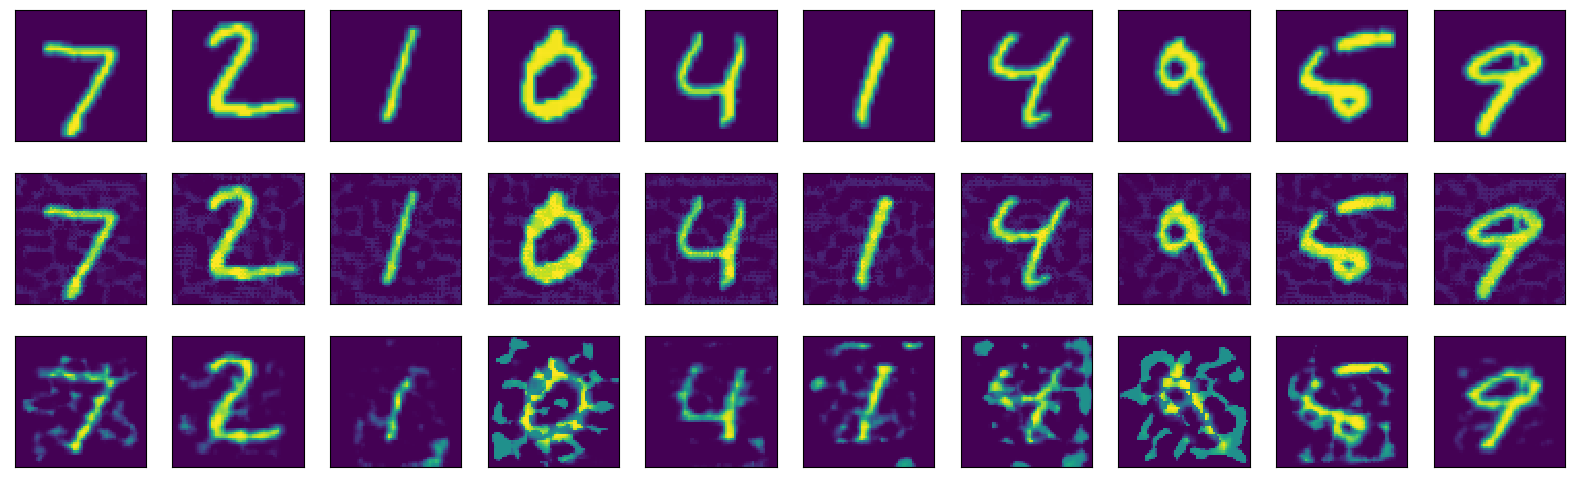

In [32]:
# Test performance of reconstruction under PGD attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# PGD attack function
def pgd_attack(model, data, epsilon, alpha, num_iter):
    perturbed_data = data.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(perturbed_data)
        loss = F.binary_cross_entropy(output, data)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_data += alpha * perturbed_data.grad.sign()
            perturbed_data = torch.clamp(perturbed_data, 0, 1)
            perturbed_data = torch.max(torch.min(perturbed_data, data + epsilon), data - epsilon)
            perturbed_data = perturbed_data.detach().requires_grad_(True)
    return perturbed_data

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# # Remove digits 2 and 3 from the test dataset
# test_dataset.data = test_dataset.data[(test_dataset.targets != 2) & (test_dataset.targets != 3)]
# test_dataset.targets = test_dataset.targets[(test_dataset.targets != 2) & (test_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Function to filter out only the digits 2 and 3
# def filter_2_and_3(data, target):
#     mask = (target == 2) | (target == 3)
#     return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# # Filter out only the digits 2 and 3
# data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.3  # Maximum perturbation
alpha = 0.01   # Step size
num_iter = 10  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(best_model, data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = best_model(perturbed_data)

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data.cpu(), perturbed_data.cpu(), recon_batch.cpu())


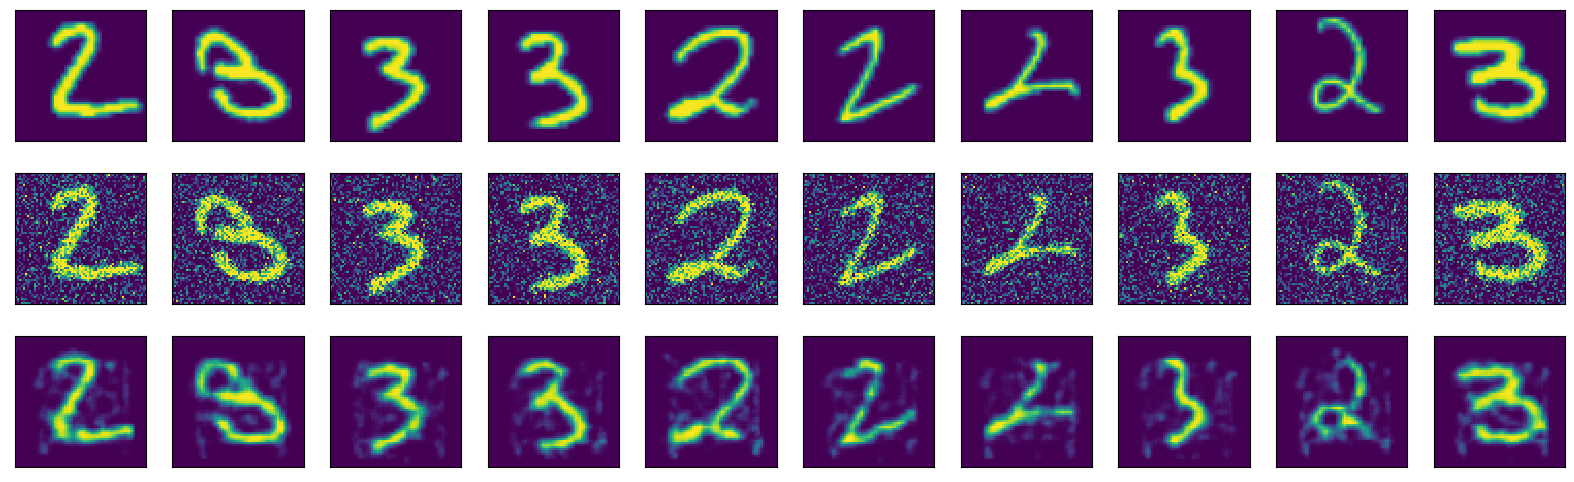

In [33]:
# Test performance of reconstruction under Gaussian noise attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Gaussian noise attack function
def gaussian_noise_attack(data, std):
    noise = torch.randn_like(data) * std
    perturbed_data = data + noise
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

# Plot original images, Gaussian noise attacked images, and reconstructed Gaussian noise attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display Gaussian noise attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed Gaussian noise attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set Gaussian noise attack parameters
std = 0.3  # Noise standard deviation

# Generate adversarial samples using Gaussian noise
perturbed_data = gaussian_noise_attack(data, std)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = best_model(perturbed_data)

# Plot original images, Gaussian noise attacked images, and reconstructed Gaussian noise attacked images
plot_images(data.cpu(), perturbed_data.cpu(), recon_batch.cpu())


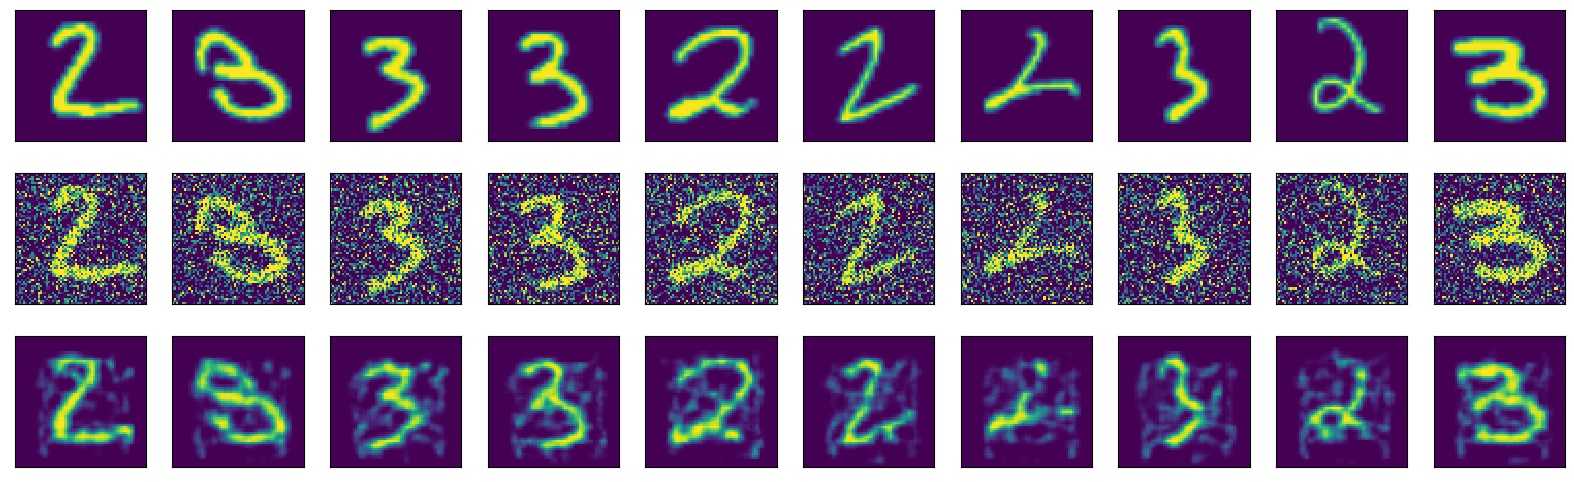

In [34]:
# Test performance of reconstruction under Gaussian noise attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Gaussian noise attack function
def gaussian_noise_attack(data, std):
    noise = torch.randn_like(data) * std
    perturbed_data = data + noise
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

# Plot original images, Gaussian noise attacked images, and reconstructed Gaussian noise attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display Gaussian noise attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed Gaussian noise attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set Gaussian noise attack parameters
std = 0.5  # Noise standard deviation

# Generate adversarial samples using Gaussian noise
perturbed_data = gaussian_noise_attack(data, std)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = best_model(perturbed_data)

# Plot original images, Gaussian noise attacked images, and reconstructed Gaussian noise attacked images
plot_images(data.cpu(), perturbed_data.cpu(), recon_batch.cpu())


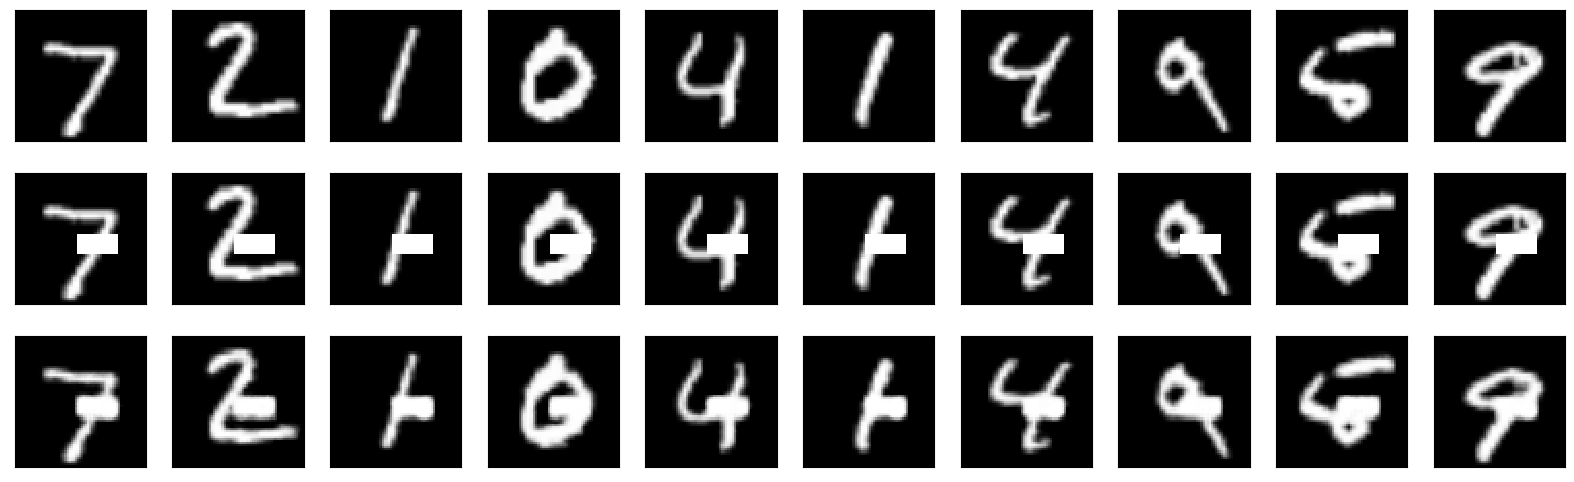

In [35]:
# Test reconstruction of the models under a patch attack
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# Patch attack function
def add_white_bar_to_images(images, bar_width, bar_height, start_x, start_y):
    modified_images = images.clone()
    modified_images[:, :, start_y:start_y+bar_height, start_x:start_x+bar_width] = 1.0
    return modified_images

# Parameters for the white bar
bar_width = 20
bar_height = 10
start_x = 30
start_y = 30

# Plot original images, patched images, and reconstructed images
def plot_images(original_images, patched_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    patched_images = patched_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display patched images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(patched_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed patched images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Add white bar to the images
data_with_bar = add_white_bar_to_images(data, bar_width, bar_height, start_x, start_y)

# Pass the images with the white bar through the model
recon_batch_with_bar = best_model(data_with_bar)[0]

# Plot the original images, images with the white bar, and their reconstructions
plot_images(data, data_with_bar, recon_batch_with_bar)


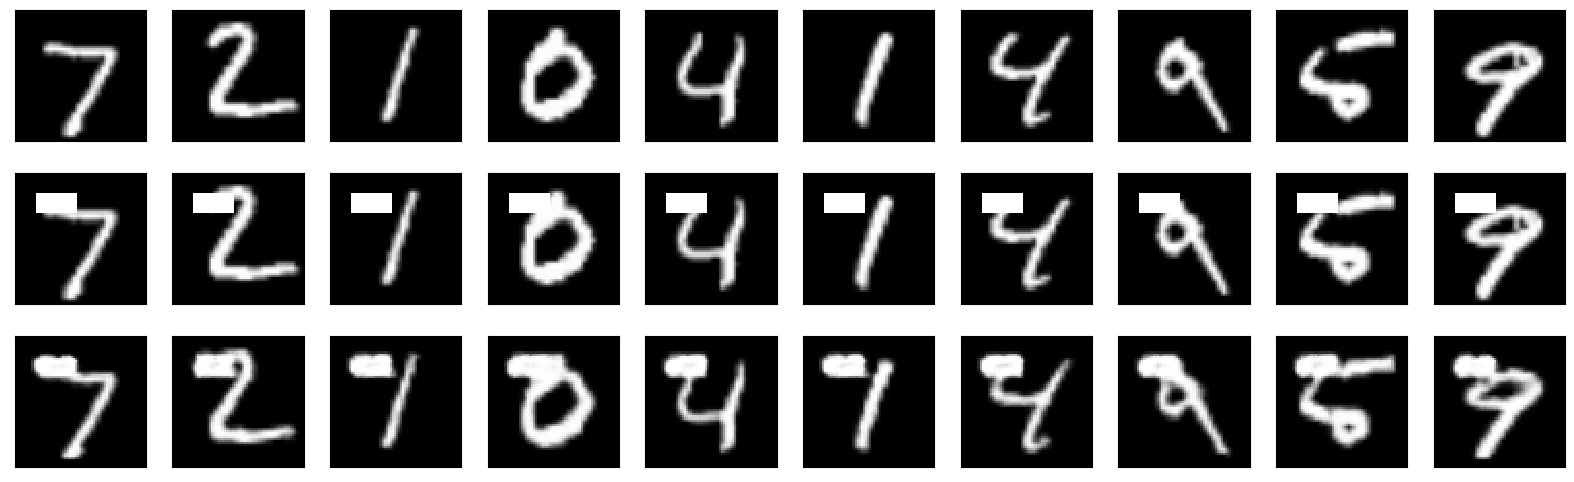

In [36]:
# Test reconstruction of the models under a patch attack
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# Patch attack function
def add_white_bar_to_images(images, bar_width, bar_height, start_x, start_y):
    modified_images = images.clone()
    modified_images[:, :, start_y:start_y+bar_height, start_x:start_x+bar_width] = 1.0
    return modified_images

# Parameters for the white bar
bar_width = 20
bar_height = 10
start_x = 10
start_y = 10

# Plot original images, patched images, and reconstructed images
def plot_images(original_images, patched_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    patched_images = patched_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display patched images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(patched_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed patched images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Add white bar to the images
data_with_bar = add_white_bar_to_images(data, bar_width, bar_height, start_x, start_y)

# Pass the images with the white bar through the model
recon_batch_with_bar = best_model(data_with_bar)[0]

# Plot the original images, images with the white bar, and their reconstructions
plot_images(data, data_with_bar, recon_batch_with_bar)


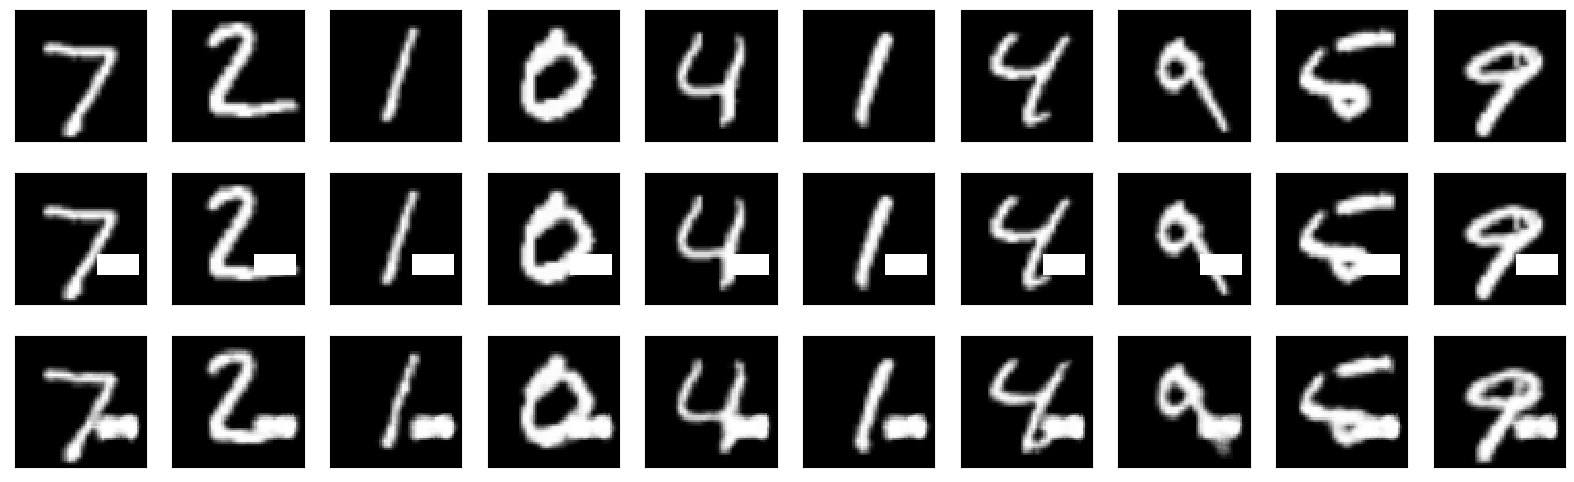

MSE Loss: 0.03720061480998993
SSIM Loss: 0.8688294712812994


In [37]:
# Test reconstruction of the models under a patch attack
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# Patch attack function
def add_white_bar_to_images(images, bar_width, bar_height, start_x, start_y):
    modified_images = images.clone()
    modified_images[:, :, start_y:start_y+bar_height, start_x:start_x+bar_width] = 1.0
    return modified_images

# Parameters for the white bar
bar_width = 20
bar_height = 10
start_x = 40
start_y = 40

# Plot original images, patched images, and reconstructed images
def plot_images(original_images, patched_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    patched_images = patched_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display patched images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(patched_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed patched images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to compute MSE loss
def mse_loss(original, reconstruction):
    return F.mse_loss(reconstruction, original).item()

# Function to compute SSIM loss
def ssim_loss(original, reconstruction):
    original = original.cpu().detach().numpy().transpose(0, 2, 3, 1)
    reconstruction = reconstruction.cpu().detach().numpy().transpose(0, 2, 3, 1)
    ssim_values = [ssim(original[i], reconstruction[i], multichannel=True) for i in range(original.shape[0])]
    return sum(ssim_values) / len(ssim_values)

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Add white bar to the images
data_with_bar = add_white_bar_to_images(data, bar_width, bar_height, start_x, start_y)

# Pass the images with the white bar through the model
recon_batch_with_bar = best_model(data_with_bar)[0]

# Plot the original images, images with the white bar, and their reconstructions
plot_images(data, data_with_bar, recon_batch_with_bar)

# Compute MSE and SSIM loss
mse = mse_loss(data, recon_batch_with_bar)
ssim_val = ssim_loss(data, recon_batch_with_bar)

print(f'MSE Loss: {mse}')
print(f'SSIM Loss: {ssim_val}')
